# Scratching Gibbs sampler for Bayesian regression

## Data description


```R
N      <- 100
a_true <- 0.4
mean1  <- 0
mean2  <- 3
sd1    <- 1
sd2    <- 1
Y      <- c(rnorm((1-a_true)*N, mean1, sd1), rnorm(a_true*N, mean2, sd2))
data   <- list(N=N, Y=Y)

write.table(Y, file="points.csv", sep=",", row.names=F, col.names=F)
```




## Model (double normal distribution)

Here we wish to find the posterior distributions of the coefficients mu(the mean) and s(the standard deviation) of a single normal distribution. The model can be written as


$$ z_i \sim \text {Bernoulli} (a) $$

$$y_i \mid z_i \sim  \mathcal{N}(\mu_{z_i}, \sigma_{z_i}^{2})$$


The likelihood for this model may be written as the product over N iid observations

$$p(y_1, \ldots, y_N \mid \mu_1, z_1, \ldots, z_N) = \prod_{i = 1}^{N} \mathcal{N}(y_i\mid \mu_{z_i}, \sigma_{z_i}^{2})$$

$ \mu_0 = 0, \sigma_0 = 1, \sigma_1 = 1 $ are known. The prior of $ \mu_1 $ $ a $ are

$$\mu_1 \sim \text{uniform}(-\infty, \infty) $$ 

$$a \sim \text{uniform}(0, 1) $$ 


## Pythonic setup

In [1]:
import numpy as np
# np.random.seed(0)

import scipy as sp

import pandas as pd
pd.set_option('display.width', 200)

% matplotlib inline
from seaborn import plt
plt.rcParams['figure.figsize'] = (10, 5)

## Deriving Gibbs sampler

### Update for $mu_1$

We are interested in finding

$$
\begin{eqnarray}
p(\mu_1 \mid a, z, y) &\propto& p(y \mid \mu_1, z) \\
&=& \prod_{i = 1}^{N} \mathcal{N}(y_i \mid \mu_{z_i}, \sigma_{z_i}^{2}) \\
&\propto& \prod \mathcal{N}(y_i\mid \mu_{z_i}, \sigma_{z_i}^{2})\mid_{z_i=1} \\
\end{eqnarray}
$$

$$ \mu_1 \mid z_1, \ldots, z_N, y \sim \mathcal{N}\left( \frac{1} {\sum^{N}_{i=1} z_i} \sum y_i\mid_{z_i=1}, \frac {1} {\sum^{N}_{i=1} z_i} \right)$$


I turn into a python function:

In [2]:
def sample_mu_1(y, z):
    N1 = np.sum(z)
    mean = np.sum(y * z) / N1
    variance = 1 / N1
    return np.random.normal(mean, np.sqrt(variance))

### Update for $ a $ 


$$
\begin{eqnarray}
p(a \mid \mu_1, z, y) &\propto& \prod_{i=1}^{N} \text{Bernoulli}(z_i \mid a) \\
&=& (1-a)^{N-\sum_{i=1}^{N} z_i} a^{\sum_{i=1}^{N} z_i}
\end{eqnarray}
$$


$$
p(a\mid \mu_1, z, y) = \text {Beta} \left( \sum_{i=1}^{N} z_i + 1, N - \sum_{i=1}^{N} z_i + 1 \right)
$$


In [3]:
def sample_a(z, a):
    alpha = np.sum(z) + 1
    beta = len(z) - alpha + 2
    return np.random.beta(alpha, beta)

### Update for z

$$
\begin{eqnarray}
p(z_i \mid \mu_1, a, z_1, \ldots,z_{i-1}, z_{i+1}, \ldots, z_N, y) &\propto& p(y \mid \mu_1, z_1, \ldots, z_N) p(z_i\mid a) \\
&\propto& \mathcal{N}(y_i \mid \mu_{z_i}, \sigma_{z_i}^{2}) \times \text{Bernoulli}(z_i \mid a) \\
\end{eqnarray}
$$


I can now code this into python. np.random.gamma uses the shape and scale parameterisation of a Gamma distribution, where the shape $k = \alpha$ but the scale $\theta=1/\beta $, hence we need to invert our expression for $\beta$ before sampling:

In [4]:
norm0 = sp.stats.norm(0, 1)

def sample_and_update_z(y, mu_1, a, z):
    norm1 = sp.stats.norm(mu_1, 1)

    for i in range(len(y)):
        d0 = (1-a) * norm0.pdf(y[i])
        d1 = a * norm1.pdf(y[i])
        z[i] = 0 if np.random.uniform() * (d0+d1) < d0 else 1

## Writing the Gibbs sampler

Now we ready to write the Gibbs sampler. Apart from the data we need to supply initial parameter estimates.

In [5]:
init = {"mu_1": np.random.uniform(-100, 100), "a": np.random.rand(), "z": np.random.randint(0, 2, 100)}
print(init)

{'mu_1': -81.10793797436156, 'a': 0.38471185958020826, 'z': array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0])}


In [6]:
def model2(y, iters, init):
    mu_1 = init["mu_1"]
    a = init["a"]
    z = init["z"]
    N = len(y)
    
    trace = np.zeros((iters, 2))
    log_likelihoods = np.zeros((iters, N))
    
    for i in range(iters):
        mu_1 = sample_mu_1(y, z)
        a = sample_a(z, a)
        sample_and_update_z(y, mu_1, a, z)
        trace[i, :] = np.array((mu_1, a))
        
        norm1 = sp.stats.norm(mu_1, 1)
        log_likelihoods[i, :] = \
            np.array([np.log((1-a)*norm0.pdf(x) + a*norm1.pdf(x)) for x in y])
    
    trace = pd.DataFrame(trace)
    trace.columns = ['mu_1', 'a']
    
    log_likelihoods = pd.DataFrame(log_likelihoods)
    
    return trace, log_likelihoods

In [7]:
iters = 5000
y = np.array([float(x) for x in open("points.csv", "r").read().strip().split("\n")])
trace, log_likelihoods = model2(y, iters, init)

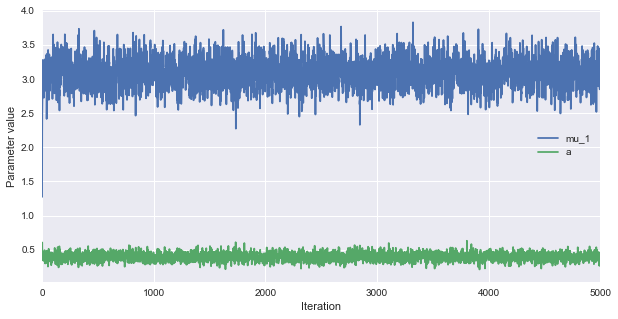

In [8]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

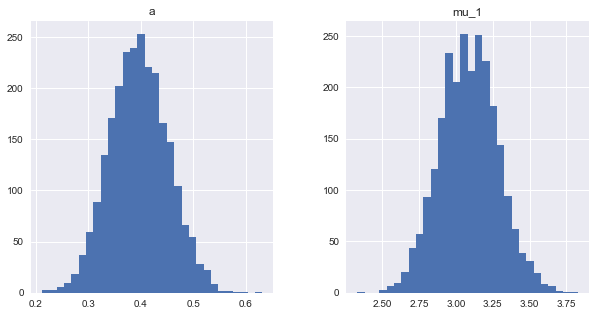

In [9]:
trace_burnt = trace[int(len(trace)/2):]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,2))

I code the WAIC and WBIC functions.

In [10]:
def waic(log_likelihoods):
    training_error = -np.log(np.exp(log_likelihoods).mean(axis=0)).mean()
    functional_variance_div_N = (np.power(log_likelihoods, 2).mean(axis=0) -
                                 np.power(log_likelihoods.mean(axis=0),2)).mean()
    return training_error + functional_variance_div_N

def wbic(log_likelihoods):
    return -log_likelihoods.sum(axis=1).mean()


I can report the descriptive statistics of mu and s, and WAIC/WBIC of current model(single normal distribution).

In [11]:
print(trace_burnt.describe().T)
print("waic:", waic(log_likelihoods))
print("wbic:", wbic(log_likelihoods))

       count      mean       std       min       25%       50%       75%       max
mu_1  2500.0  3.087879  0.197851  2.328777  2.950856  3.084685  3.220114  3.828030
a     2500.0  0.397003  0.055714  0.211999  0.358266  0.396206  0.434202  0.631361
waic: 1.91442576613
wbic: 190.363686428


## Compare to Rstan

Finally we run the regression and WAIC/WBIC calculation with R and stan. The result and code are above. The result is similar to that of my scratched Gibbs sampling.

In [12]:
from subprocess import check_output

print(check_output(["Rscript", "run.r"]).decode("utf8"))

# results of the single normal distribution model with Rstan
        mean      se_mean         sd      2.5%       25%       50%       75%     97.5%    n_eff     Rhat
mu 3.0930233 0.0011398696 0.19934557 2.7020393 2.9601138 3.0924020 3.2278038 3.4861748 30584.60 1.000080
a  0.3963891 0.0003309912 0.05569274 0.2905625 0.3582446 0.3951649 0.4335651 0.5073475 28311.59 1.000046

                              WAIC     WBIC
single normal dist. model 1.913717 190.3411



In [13]:
for n, i in enumerate(open("run.r", "r"), 1):
    print("{:2d} {}".format(n, i), end="")

 1 options(width=200)
 2 set.seed(1)
 3 
 4 N      <- 100
 5 a_true <- 0.4
 6 mean1  <- 0
 7 mean2  <- 3
 8 sd1    <- 1
 9 sd2    <- 1
10 Y      <- c(rnorm((1-a_true)*N, mean1, sd1), rnorm(a_true*N, mean2, sd2))
11 data   <- list(N=N, Y=Y)
12 
13 write.table(Y, file="points.csv", sep=",", row.names=F, col.names=F)
14 
15 model2 <- "
16 data {
17   int<lower=1> N;
18   vector[N] Y;
19 }
20 
21 parameters {
22   real<lower=0, upper=1> a;
23   real<lower=-50, upper=50> mu;
24 }
25 
26 model {
27   for(n in 1:N){
28     target += log_sum_exp(
29       log(1-a) + normal_lpdf(Y[n] | 0, 1),
30       log(a) + normal_lpdf(Y[n] | mu, 1)
31     );
32   }
33 }
34 
35 generated quantities {
36   vector[N] log_likelihood;
37   int index;
38   real y_pred;
39   for(n in 1:N)
40     log_likelihood[n] = log_sum_exp(
41       log(1-a) + normal_lpdf(Y[n] | 0, 1),
42       log(a) + normal_lpdf(Y[n] | mu, 1)
43     );
44   index = bernoulli_rng(a);
45   y_pred = normal_rng(index == 1 ? mu: 0, 1);
46 }
47 "

## references

- http://kieranrcampbell.github.io/gibbs-sampling-bayesian-linear-regression/
- http://statmodeling.hatenablog.com/entry/calc-waic-wbic